## Iteration 1
---

Combined Code 1,2,3 from the lecture

### Target
- Have a basic working code
- Have a skeleton code to build upon
- Make it as light as possible without adding any normalisation, regularisation, etc.

### Results

- Parameters: 9.6k
- Best Train accuracy: 99.15
- Best Test accuracy: 98.85

### Analysis

- Good model
- No overfitting
- Can be better if trained more

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
SEED = 69

torch.manual_seed(SEED)

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3) # 28>26 | 3
        self.conv2 = nn.Conv2d(8, 8, 3) # 26 > 24 |  5
        self.conv3 = nn.Conv2d(8, 16, 3) # 24> 22 | 7
        self.pool2 = nn.MaxPool2d(2, 2) # 22 > 11 | 14
        self.conv4 = nn.Conv2d(16, 16, 3) #11 > 9 | 16
        self.conv5 = nn.Conv2d(16, 16, 3) # 9 > 7 | 18
        self.conv6 = nn.Conv2d(16, 8, 3) # 7 > 5 | 20
        self.conv7 = nn.Conv2d(8, 10, 5) # 5 > 1 | 24 | > 1x1x10

    def forward(self, x):
        x = F.relu(self.conv2(F.relu(self.conv1(x))))
        x = self.pool2(F.relu(self.conv3(x)))
        x = F.relu(self.conv6(F.relu(self.conv5(F.relu(self.conv4(x))))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10) #1x1x10> 10
        return F.log_softmax(x, dim=-1)

In [7]:
!pip install torchsummary
from torchsummary import summary
device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
            Conv2d-2            [-1, 8, 24, 24]             584
            Conv2d-3           [-1, 16, 22, 22]           1,168
         MaxPool2d-4           [-1, 16, 11, 11]               0
            Conv2d-5             [-1, 16, 9, 9]           2,320
            Conv2d-6             [-1, 16, 7, 7]           2,320
            Conv2d-7              [-1, 8, 5, 5]           1,160
            Conv2d-8             [-1, 10, 1, 1]           2,010
Total params: 9,642
Trainable params: 9,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.04
Estimated Total Size (MB): 0.21
-------

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []

train_acc = []
test_acc = []

def train(model, device, train_loader, optimiser):
  model.train()

  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)

    optimiser.zero_grad()

    y_pred = model(data)

    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    loss.backward()
    optimiser.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
  model.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:

      data, target = data.to(device), target.to(device)

      output = model(data)

      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
  test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
model = Net().to(device)

optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15

for epoch in range(EPOCHS):
  print("epoch:", epoch)
  train(model, device, train_loader, optimiser)
  test(model, device, test_loader)

epoch: 0


Loss=0.1375667005777359 Batch_id=468 Accuracy=63.31: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]



Test set: Average loss: 0.1501, Accuracy: 9538/10000 (95.38%)

epoch: 1


Loss=0.18947851657867432 Batch_id=468 Accuracy=95.88: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]



Test set: Average loss: 0.0964, Accuracy: 9700/10000 (97.00%)

epoch: 2


Loss=0.07390672713518143 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]



Test set: Average loss: 0.0760, Accuracy: 9761/10000 (97.61%)

epoch: 3


Loss=0.09120112657546997 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:14<00:00, 33.32it/s]



Test set: Average loss: 0.0639, Accuracy: 9796/10000 (97.96%)

epoch: 4


Loss=0.05678984150290489 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:14<00:00, 32.82it/s]



Test set: Average loss: 0.0557, Accuracy: 9819/10000 (98.19%)

epoch: 5


Loss=0.05641847476363182 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 31.53it/s]



Test set: Average loss: 0.0548, Accuracy: 9821/10000 (98.21%)

epoch: 6


Loss=0.10941853374242783 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]



Test set: Average loss: 0.0494, Accuracy: 9847/10000 (98.47%)

epoch: 7


Loss=0.010446415282785892 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]



Test set: Average loss: 0.0410, Accuracy: 9873/10000 (98.73%)

epoch: 8


Loss=0.01716841757297516 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]



Test set: Average loss: 0.0459, Accuracy: 9859/10000 (98.59%)

epoch: 9


Loss=0.022405656054615974 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]



Test set: Average loss: 0.0453, Accuracy: 9857/10000 (98.57%)

epoch: 10


Loss=0.030962945893406868 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]



Test set: Average loss: 0.0374, Accuracy: 9883/10000 (98.83%)

epoch: 11


Loss=0.0096346540376544 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]



Test set: Average loss: 0.0403, Accuracy: 9876/10000 (98.76%)

epoch: 12


Loss=0.01886487565934658 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]



Test set: Average loss: 0.0435, Accuracy: 9864/10000 (98.64%)

epoch: 13


Loss=0.0934346616268158 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]



Test set: Average loss: 0.0392, Accuracy: 9870/10000 (98.70%)

epoch: 14


Loss=0.005543360020965338 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]



Test set: Average loss: 0.0386, Accuracy: 9885/10000 (98.85%)



Text(0.5, 1.0, 'Test Accuracy')

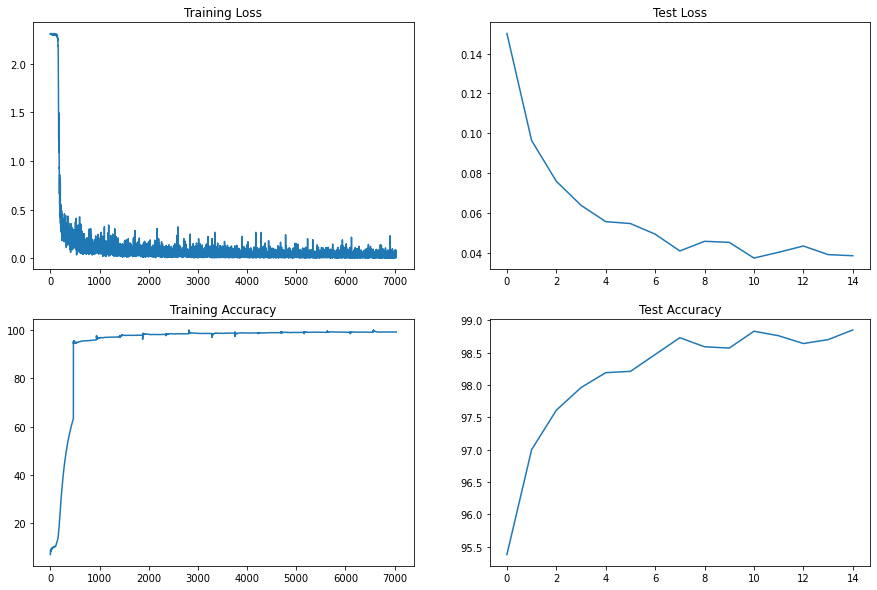

In [17]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")